# CartoonGAN (Expt - with added dropout and Residual Blocks in Generator)

## Install & Import dependencies

apt-get update && apt-get install ffmpeg libsm6 libxext6 -y

In [1]:
!pip install -q numpy matplotlib tensorboard opencv-python scikit-image

In [2]:
import os
import cv2
import math
import time
import torch
import numpy as np
import torch.nn as nn
from tqdm import tqdm
from torch import sigmoid
import torch.optim as optim
from torchvision import models
import matplotlib.pyplot as plt
import torch.nn.functional as F
from PIL import Image, ImageFilter
from skimage.filters import gaussian
from skimage import io, img_as_ubyte
from torchvision import transforms as T
from torchvision.datasets import ImageFolder
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split


## Generate dataset

### cartoons images

- extract images and place in folder `cartoons` by executing cell below

##### data-loader

In [3]:
image_size = 256
batch_size = 32

In [4]:
transformer = T.Compose([
    T.CenterCrop(image_size),  # Resize the image to 256x256
    T.ToTensor()  # Convert the image to a PyTorch tensor
])

cartoon_dataset = ImageFolder('data/train/cartoons/', transformer)
len_training_set = math.floor(len(cartoon_dataset) * 0.9)
len_valid_set = len(cartoon_dataset) - len_training_set

training_set, _ = random_split(cartoon_dataset, (len_training_set, len_valid_set))
cartoon_image_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)

#### show examples

torch.Size([3, 256, 256])
Current range: 0.0 to 1.0


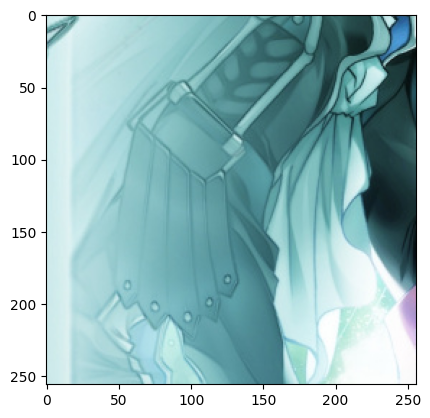

In [5]:
def show_sample_image(dataloader):
  iterator = iter(dataloader)
  sample_batch, _ = next(iterator)
  first_sample_image_of_batch = sample_batch[0]
  print(first_sample_image_of_batch.size())
  print("Current range: {} to {}".format(first_sample_image_of_batch.min(), first_sample_image_of_batch.max()))
  plt.imshow(np.transpose(first_sample_image_of_batch.numpy(), (1, 2, 0)))

show_sample_image(cartoon_image_dataloader_train)

### edge-smoothed cartoons images

- extract images and place in folder `cartoons_smoothed` by executing cell below

##### data-loader

same configuration as cartoon data loader above

In [6]:
smoothed_cartoon_dataset = ImageFolder('data/train/cartoons_smoothed/', transformer)
len_training_set = math.floor(len(smoothed_cartoon_dataset) * 0.9)
len_valid_set = len(smoothed_cartoon_dataset) - len_training_set
training_set, _ = random_split(smoothed_cartoon_dataset, (len_training_set, len_valid_set))
smoothed_cartoon_image_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)

#### show examples

torch.Size([3, 256, 256])
Current range: 0.0 to 1.0


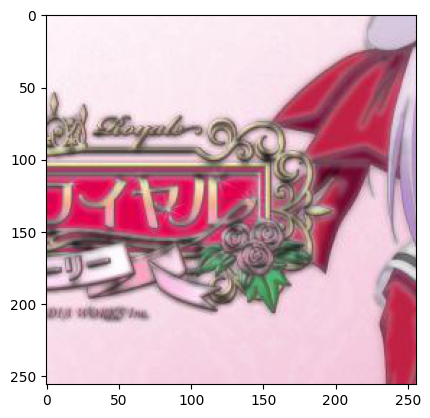

In [7]:
show_sample_image(smoothed_cartoon_image_dataloader_train)

### photos

- extract images and place in folder `real` by executing cell below

##### data-loader
same configuration as cartoon data loader above

In [8]:
photo_dataset = ImageFolder('data/train/real/', transformer)
len_training_set = math.floor(len(photo_dataset) * 0.9)
len_valid_set = len(photo_dataset) - len_training_set
training_set, validation_set = random_split(photo_dataset, (len_training_set, len_valid_set))
photo_dataloader_train = DataLoader(training_set, batch_size, shuffle=True, num_workers=0)
photo_dataloader_valid = DataLoader(validation_set, batch_size, shuffle=True, num_workers=0)

#### show examples

torch.Size([3, 256, 256])
Current range: 0.0 to 1.0


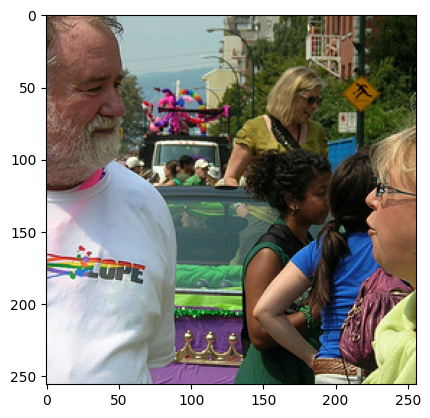

In [9]:
show_sample_image(photo_dataloader_train)

## Setup tensorboard

Use tensorboard to have an eye on weights and losses.

In [10]:
tensorboard_logdir = 'tensorboard'
writer = SummaryWriter(tensorboard_logdir)

### Generator

In [31]:
class ResidualBlock(nn.Module):
  def __init__(self):
    super(ResidualBlock, self).__init__()
    self.conv_1 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.conv_2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
    self.norm_1 = nn.BatchNorm2d(256)
    self.norm_2 = nn.BatchNorm2d(256)

  def forward(self, x):
    output = self.norm_2(self.conv_2(F.relu(self.norm_1(self.conv_1(x)))))
    return output + x 

class Generator(nn.Module):
    def __init__(self):
      super(Generator, self).__init__()
      self.conv_1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=7, stride=1, padding=3)
      self.norm_1 = nn.BatchNorm2d(64)
      
      # down-convolution #
      self.conv_2 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
      self.conv_3 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.norm_2 = nn.BatchNorm2d(128)
      
      self.conv_4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
      self.conv_5 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
      self.norm_3 = nn.BatchNorm2d(256)
    
      # residual blocks #
      residualBlocks = []
      for l in range(10):
        residualBlocks.append(ResidualBlock())
      self.res = nn.Sequential(*residualBlocks)

      # dropout
      self.dropout = nn.Dropout(0.25)
        
      # up-convolution #
      self.conv_6 = nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size=3, stride=2, padding=1, output_padding=1)
      self.conv_7 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1)
      self.norm_4 = nn.BatchNorm2d(128)

      self.conv_8 = nn.ConvTranspose2d(in_channels=128, out_channels=64, kernel_size=3, stride=2, padding=1, output_padding=1)
      self.conv_9 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
      self.norm_5 = nn.BatchNorm2d(64)
      
      self.conv_10 = nn.Conv2d(in_channels=64, out_channels=3, kernel_size=7, stride=1, padding=3)

    def forward(self, x):
      x = F.relu(self.norm_1(self.conv_1(x)))
      
      x = F.relu(self.norm_2(self.conv_3(self.conv_2(x))))
      x = self.dropout(x)

      x = F.relu(self.norm_3(self.conv_5(self.conv_4(x))))
      
      x = self.res(x)
      x = F.relu(self.norm_4(self.conv_7(self.conv_6(x))))
      x = self.dropout(x)
      x = F.relu(self.norm_5(self.conv_9(self.conv_8(x))))

      x = self.conv_10(x)

      x = sigmoid(x)

      return x

In [32]:
G = Generator()
print(G)

Generator(
  (conv_1): Conv2d(3, 64, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (norm_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_2): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (res): Sequential(
    (0): ResidualBlock(
      (conv_1): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (conv_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm_1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

### Discriminator

In [33]:
class Discriminator(nn.Module):
  def __init__(self):
     super(Discriminator, self).__init__()
     self.conv_1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
      
     self.conv_2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
     self.conv_3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
     self.norm_1 = nn.BatchNorm2d(128)
      
     self.conv_4 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, stride=2, padding=1)
     self.conv_5 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=1, padding=1)
     self.norm_2 = nn.BatchNorm2d(256)
    
     self.conv_6 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, stride=1, padding=1)
     self.norm_3 = nn.BatchNorm2d(256)
    
     self.conv_7 = nn.Conv2d(in_channels=256, out_channels=1, kernel_size=3, stride=1, padding=1)

  def forward(self, x):
    x = F.leaky_relu(self.conv_1(x))
    x = F.leaky_relu(self.norm_1(self.conv_3(F.leaky_relu(self.conv_2(x)))), negative_slope=0.2)
    x = F.leaky_relu(self.norm_2(self.conv_5(F.leaky_relu(self.conv_4(x)))), negative_slope=0.2)
    x = F.leaky_relu(self.norm_3(self.conv_6(x)), negative_slope=0.2)
    x = self.conv_7(x)
    x = sigmoid(x)
    
    return x

In [34]:
D = Discriminator()
print(D)

Discriminator(
  (conv_1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_4): Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (conv_5): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_2): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_6): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (norm_3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_7): Conv2d(256, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)


### use device CPU or GPU

In [35]:
device = torch.device('cpu')

if torch.cuda.is_available():
  device = torch.device('cuda')
  print("Train on GPU.")
else:
  print("No cuda available")

G.to(device)
D.to(device)

device

Train on GPU.


device(type='cuda')

### VGG-16
Load already downloaded vgg-16 weights from drive, or download and save to drive.

In [36]:
path_to_pretrained_vgg16 = "vgg16_weights.pth"

vgg16 = models.vgg16(pretrained=True)
torch.save(vgg16, path_to_pretrained_vgg16)
vgg16 = vgg16.to(device) 
print(vgg16)


feature_extractor = vgg16.features[:24]
for param in feature_extractor.parameters():
  param.require_grad = False

print(feature_extractor)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

### Two loss functions

- discriminator loss
- generator initialization phase loss and generator loss

In [37]:
from torchvision import models
from torch.nn import BCELoss

class DiscriminatorLoss(torch.nn.Module):
  def __init__(self):
      super(DiscriminatorLoss, self).__init__()
      self.bce_loss = BCELoss()

  def forward(self, discriminator_output_of_cartoon_input,
              discriminator_output_of_cartoon_smoothed_input,
              discriminator_output_of_generated_image_input,
              epoch,
              write_to_tensorboard=False):

    return self._adversarial_loss(discriminator_output_of_cartoon_input,
                     discriminator_output_of_cartoon_smoothed_input,
                     discriminator_output_of_generated_image_input,
                     epoch,
                     write_to_tensorboard)

  def _adversarial_loss(self, discriminator_output_of_cartoon_input,
                     discriminator_output_of_cartoon_smoothed_input,
                     discriminator_output_of_generated_image_input,
                     epoch,
                     write_to_tensorboard):

   
    actual_batch_size = discriminator_output_of_cartoon_input.size()[0]
    zeros = torch.zeros([actual_batch_size, 1, 64, 64]).to(device)
    ones = torch.ones([actual_batch_size, 1, 64, 64]).to(device)

    d_loss_cartoon = self.bce_loss(discriminator_output_of_cartoon_input, ones)
    d_loss_cartoon_smoothed = self.bce_loss(discriminator_output_of_cartoon_smoothed_input, zeros)
    d_loss_generated_input = self.bce_loss(discriminator_output_of_generated_image_input, zeros)

    d_loss = d_loss_cartoon + d_loss_cartoon_smoothed + d_loss_generated_input

    if write_to_tensorboard:
      writer.add_scalar('d_loss_cartoon', d_loss_cartoon,epoch)
      writer.add_scalar('d_loss_cartoon_smoothed', d_loss_cartoon_smoothed, epoch)
      writer.add_scalar('d_loss_generated_input', d_loss_generated_input, epoch)
      writer.add_scalar('d_loss', d_loss, epoch)

    return d_loss

In [38]:
class GeneratorLoss(torch.nn.Module):
  def __init__(self):
      super(GeneratorLoss, self).__init__()
      self.w = 0.000005
      self.bce_loss = BCELoss()
      self.feature_extractor = vgg16.features[:24]
      for param in self.feature_extractor.parameters():
        param.require_grad = False

  def forward(self, discriminator_output_of_generated_image_input,
              generator_input,
              generator_output,
              epoch,
              is_init_phase=False,
              write_to_tensorboard=False):
    if is_init_phase:
      g_content_loss = self._content_loss(generator_input, generator_output)
      g_adversarial_loss = 0.0
      g_loss = g_content_loss
    else:
      g_adversarial_loss = self._adversarial_loss_generator_part_only(discriminator_output_of_generated_image_input)
      g_content_loss = self._content_loss(generator_input, generator_output)
      g_loss = g_adversarial_loss + self.w * g_content_loss

    if write_to_tensorboard:
      writer.add_scalar('g_adversarial_loss', g_adversarial_loss, epoch)
      writer.add_scalar('g_content_loss', g_content_loss, epoch)
      writer.add_scalar('g_loss', g_loss, epoch)

    return g_loss

  def _adversarial_loss_generator_part_only(self, discriminator_output_of_generated_image_input):
    actual_batch_size = discriminator_output_of_generated_image_input.size()[0]
    ones = torch.ones([actual_batch_size, 1, 64, 64]).to(device)
    return self.bce_loss(discriminator_output_of_generated_image_input, ones)

  def _content_loss(self, generator_input, generator_output):
    return (self.feature_extractor(generator_output) - self.feature_extractor(generator_input)).norm(p=1)

In [39]:
discriminatorLoss = DiscriminatorLoss()
generatorLoss = GeneratorLoss()

## Optimizer

In [40]:

lr = 0.0002
beta1 = 0.5
beta2 = 0.999

d_optimizer = optim.Adam(D.parameters(), lr, [beta1, beta2])
g_optimizer = optim.Adam(G.parameters(), lr, [beta1, beta2])

## Saving
To make training resumeable, I save some checkpoints to google drive and load them, if existing, before run the training.

I also save weights and bias from generator and discriminator to tensorboard.

For checking some intermediate images of the generator, I save them to google drive.

In [41]:
intermediate_results_training_path = "intermediate_results/training/"
!mkdir -p intermediate_results/training/

In [42]:
def save_training_result(input, output):
  # input/output has batch-size number of images, get first one and detach from tensor
  image_input = input[0].detach().cpu().numpy()
  image_output = output[0].detach().cpu().numpy()
  # transponse image from torch.Size([3, 256, 256]) to (256, 256, 3)
  image_input = np.transpose(image_input, (1, 2, 0))
  image_output = np.transpose(image_output, (1, 2, 0))

  # generate filenames as timestamp, this orders the output by time
  filename = str(int(time.time()))
  path_input = intermediate_results_training_path + filename + "_input.jpg"
  path_output = intermediate_results_training_path + filename + ".jpg"
  plt.imsave(path_input, image_input)
  plt.imsave(path_output, image_output)

In [43]:
def write_model_weights_and_bias_to_tensorboard(prefix, state_dict, epoch):
  for param in state_dict:
      writer.add_histogram(f"{prefix}_{param}", state_dict[param], epoch)

## Training

In [44]:
def train(_num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses):
    init_epochs = 10
    print_every = 100
    start_time = time.time()

    for epoch in range(epochs_already_done, _num_epochs):
        epoch_losses = []  # to store losses for this epoch
        for index, ((photo_images, _), (smoothed_cartoon_images, _), (cartoon_images, _)) in enumerate(zip(photo_dataloader_train, smoothed_cartoon_image_dataloader_train, cartoon_image_dataloader_train)):
            batch_size = photo_images.size(0)
            photo_images = photo_images.to(device)
            smoothed_cartoon_images = smoothed_cartoon_images.to(device)
            cartoon_images = cartoon_images.to(device)

            # training the discriminator
            d_optimizer.zero_grad()
            d_of_cartoon_input = D(cartoon_images)
            d_of_cartoon_smoothed_input = D(smoothed_cartoon_images)
            d_of_generated_image_input = D(G(photo_images))
            d_loss = discriminatorLoss(d_of_cartoon_input,
                                        d_of_cartoon_smoothed_input,
                                        d_of_generated_image_input,
                                        epoch)
            d_loss.backward()
            d_optimizer.step()

            # training the generator
            g_optimizer.zero_grad()
            g_output = G(photo_images)
            d_of_generated_image_input = D(g_output)
            init_phase = epoch < init_epochs
            g_loss = generatorLoss(d_of_generated_image_input,
                                   photo_images,
                                   g_output,
                                   epoch,
                                   is_init_phase=init_phase)
            g_loss.backward()
            g_optimizer.step()

            # accumulate losses for this epoch
            epoch_losses.append((d_loss.item(), g_loss.item()))

        # calculate average loss for this epoch
        avg_d_loss = sum([l[0] for l in epoch_losses]) / len(epoch_losses)
        avg_g_loss = sum([l[1] for l in epoch_losses]) / len(epoch_losses)
        losses.append((avg_d_loss, avg_g_loss))

        # print losses for the entire epoch
        now = time.time()
        current_run_time = now - start_time
        start_time = now
        print("Epoch [{}/{}] | Average d_loss {:6.4f} | Average g_loss {:6.4f} | time {:2.0f}s".format(epoch+1, _num_epochs, avg_d_loss, avg_g_loss, current_run_time))

        # saving some intermediate results during training
        save_training_result(photo_images, g_output)

        # validating
        with torch.no_grad():
            D.eval()
            G.eval()
            valid_losses = []
            for batch_index, (photo_images, _) in enumerate(photo_dataloader_valid):
                photo_images = photo_images.to(device)
                g_output = G(photo_images)
                d_of_generated_image_input = D(g_output)
                g_valid_loss = generatorLoss(d_of_generated_image_input,
                                              photo_images,
                                              g_output,
                                              epoch,
                                              is_init_phase=init_phase)
                valid_losses.append(g_valid_loss.item())

            avg_valid_loss = sum(valid_losses) / len(valid_losses)
            validation_losses.append(avg_valid_loss)
            print("Epoch [{}/{}] | Average validation loss {:6.4f}".format(epoch+1, _num_epochs, avg_valid_loss))

        D.train()
        G.train()

        if avg_valid_loss < best_valid_loss:
            print("Validation loss improved from {} to {}".format(best_valid_loss, avg_valid_loss))
            best_valid_loss = avg_valid_loss

            # saving checkpoint
            checkpoint = {'g_valid_loss': avg_valid_loss,
                          'best_valid_loss': best_valid_loss,
                          'losses': losses,
                          'validation_losses': validation_losses,
                          'last_epoch': epoch+1,
                          'd_state_dict': D.state_dict(),
                          'g_state_dict': G.state_dict(),
                          'd_optimizer_state_dict': d_optimizer.state_dict(),
                          'g_optimizer_state_dict': g_optimizer.state_dict()
                         }
            print("Save checkpoint for validation loss of {}".format(avg_valid_loss))
            torch.save(checkpoint, checkpoint_dir + '/checkpoint_epoch_{:03d}.pth'.format(epoch+1))
            if best_valid_loss == avg_valid_loss:
                print("Overwrite best checkpoint")
                torch.save(checkpoint, checkpoint_dir + '/best_checkpoint.pth')


    return losses, validation_losses


In [45]:
def train(_num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses):
  init_epochs = 10
  print_every = 100
  start_time = time.time()

  for epoch in range(_num_epochs - epochs_already_done):
    epoch = epoch + epochs_already_done

    for index, ((photo_images, _), (smoothed_cartoon_images, _), (cartoon_images, _)) in enumerate(zip(photo_dataloader_train, smoothed_cartoon_image_dataloader_train, cartoon_image_dataloader_train)):
      batch_size = photo_images.size(0)
      photo_images = photo_images.to(device)
      smoothed_cartoon_images = smoothed_cartoon_images.to(device)
      cartoon_images = cartoon_images.to(device)

      # training the discriminator
      d_optimizer.zero_grad()
      
      d_of_cartoon_input = D(cartoon_images)
      d_of_cartoon_smoothed_input = D(smoothed_cartoon_images)
      d_of_generated_image_input = D(G(photo_images))

      write_only_one_loss_from_epoch_not_every_batch_loss = (index == 0)

      d_loss = discriminatorLoss(d_of_cartoon_input,
                                 d_of_cartoon_smoothed_input,
                                 d_of_generated_image_input,
                                 epoch,
                                 write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

      d_loss.backward()
      d_optimizer.step()

      # training the generator
      g_optimizer.zero_grad()

      g_output = G(photo_images)

      d_of_generated_image_input = D(g_output)

      if epoch < init_epochs:
        # init
        init_phase = True
      else:
        # training
        init_phase = False

      g_loss = generatorLoss(d_of_generated_image_input,
                              photo_images,
                              g_output,
                              epoch,
                              is_init_phase=init_phase,
                              write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

      g_loss.backward()
      g_optimizer.step()

      if (index % print_every) == 0:
        losses.append((d_loss.item(), g_loss.item()))
        now = time.time()
        current_run_time = now - start_time
        start_time = now
        print("Epoch {}/{} | d_loss {:6.4f} | g_loss {:6.4f} | time {:2.0f}s | total no. of losses {}".format(epoch+1, _num_epochs, d_loss.item(), g_loss.item(), current_run_time, len(losses)))
    
    # writing to tensorboard
      #write_model_weights_and_bias_to_tensorboard('D', D.state_dict(), epoch)
      #write_model_weights_and_bias_to_tensorboard('G', G.state_dict(), epoch)
    # saving some intermediate results during training
    save_training_result(photo_images, g_output)

    # validating
    with torch.no_grad():
      D.eval()
      G.eval()

      for batch_index, (photo_images, _) in enumerate(photo_dataloader_valid):
        photo_images = photo_images.to(device)

        g_output = G(photo_images)
        d_of_generated_image_input = D(g_output)
        g_valid_loss = generatorLoss(d_of_generated_image_input,
                                      photo_images,
                                      g_output,
                                      epoch,
                                      is_init_phase=init_phase,
                                      write_to_tensorboard=write_only_one_loss_from_epoch_not_every_batch_loss)

        if batch_index % print_every == 0:
          validation_losses.append(g_valid_loss.item())
          now = time.time()
          current_run_time = now - start_time
          start_time = now
          print("Epoch {}/{} | validation loss {:6.4f} | time {:2.0f}s | total no. of losses {}".format(epoch+1, _num_epochs, g_valid_loss.item(), current_run_time, len(validation_losses)))

    D.train()
    G.train()
    
    if(g_valid_loss.item() < best_valid_loss):
      print("Generator loss improved from {} to {}".format(best_valid_loss, g_valid_loss.item()))
      best_valid_loss = g_valid_loss.item()
  
    # saving checkpoint
    checkpoint = {'g_valid_loss': g_valid_loss.item(),
                  'best_valid_loss': best_valid_loss,
                  'losses': losses,
                  'validation_losses': validation_losses,
                  'last_epoch': epoch+1,
                  'd_state_dict': D.state_dict(),
                  'g_state_dict': G.state_dict(),
                  'd_optimizer_state_dict': d_optimizer.state_dict(),
                  'g_optimizer_state_dict': g_optimizer.state_dict()
                }
    print("Save checkpoint for validation loss of {}".format(g_valid_loss.item()))
    torch.save(checkpoint, checkpoint_dir + '/checkpoint_epoch_{:03d}.pth'.format(epoch+1))
    if(best_valid_loss == g_valid_loss.item()):
      print("Overwrite best checkpoint")
      torch.save(checkpoint, checkpoint_dir + '/best_checkpoint.pth')
    
  return losses, validation_losses

In [46]:
from os import listdir

checkpoint_dir = 'checkpoints'
checkpoints = listdir(checkpoint_dir)
num_epochs = 200 + 10 # training + init phase
epochs_already_done = 0
best_valid_loss = math.inf
losses = []
validation_losses = []

if(len(checkpoints) > 0):
  last_checkpoint = sorted(checkpoints)[-1]
  checkpoint = torch.load(checkpoint_dir + '/' + last_checkpoint, map_location=torch.device(device))
  best_valid_loss = checkpoint['best_valid_loss']
  epochs_already_done = checkpoint['last_epoch']
  losses = checkpoint['losses']
  validation_losses = checkpoint['validation_losses']

  D.load_state_dict(checkpoint['d_state_dict'])
  G.load_state_dict(checkpoint['g_state_dict'])
  d_optimizer.load_state_dict(checkpoint['d_optimizer_state_dict'])
  g_optimizer.load_state_dict(checkpoint['g_optimizer_state_dict'])
  print('Load checkpoint {} with g_valid_loss {}, best_valid_loss {}, {} epochs and total no of losses {}'.format(last_checkpoint, checkpoint['g_valid_loss'], best_valid_loss, epochs_already_done, len(losses)))


In [47]:
losses, validation_losses = train(num_epochs, checkpoint_dir, best_valid_loss, epochs_already_done, losses, validation_losses)

Epoch 1/210 | d_loss 2.1343 | g_loss 2648948.0000 | time 28s | total no. of losses 1
Epoch 1/210 | d_loss 1.2166 | g_loss 2619781.0000 | time 1783s | total no. of losses 2
Epoch 1/210 | validation loss 2473640.5000 | time 198s | total no. of losses 1
Generator loss improved from inf to 1352664.875
Save checkpoint for validation loss of 1352664.875
Overwrite best checkpoint
Epoch 2/210 | d_loss 1.0554 | g_loss 2582173.0000 | time 31s | total no. of losses 3
Epoch 2/210 | d_loss 0.4860 | g_loss 2502037.5000 | time 1769s | total no. of losses 4
Epoch 2/210 | validation loss 2627750.0000 | time 199s | total no. of losses 2
Save checkpoint for validation loss of 1403795.75
Epoch 3/210 | d_loss 0.2058 | g_loss 2594705.7500 | time 30s | total no. of losses 5
Epoch 3/210 | d_loss 1.4523 | g_loss 2595592.5000 | time 1768s | total no. of losses 6
Epoch 3/210 | validation loss 2283131.5000 | time 198s | total no. of losses 3
Save checkpoint for validation loss of 1441880.5
Epoch 4/210 | d_loss 1.

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


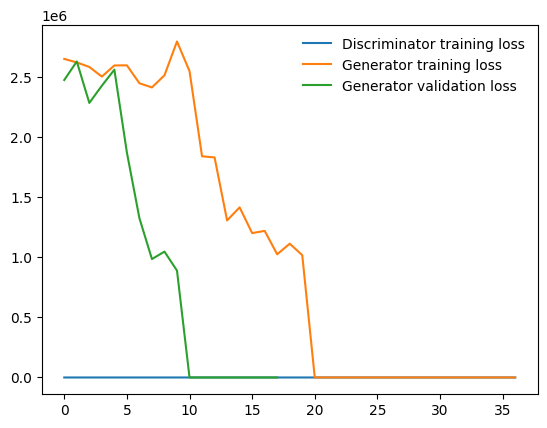

In [48]:
%matplotlib inline
%config InlineBackend.figure.format = 'retina'


d_losses = [x[0] for x in losses]
g_losses = [x[1] for x in losses]
plt.plot(d_losses, label='Discriminator training loss')
plt.plot(g_losses, label='Generator training loss')
plt.plot(validation_losses, label='Generator validation loss')
plt.legend(frameon=False)

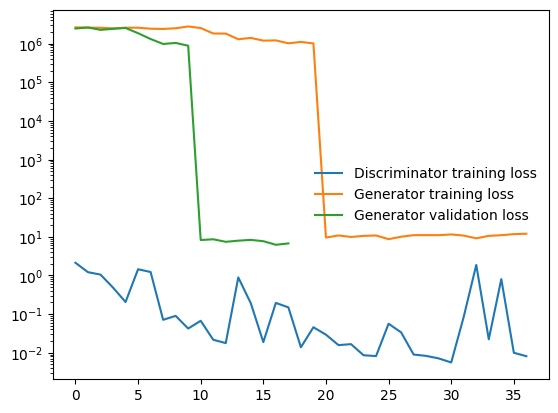

In [49]:
%matplotlib inline
%config InlineBackend.figure.format = 'retina'


d_losses = [x[0] for x in losses]
g_losses = [x[1] for x in losses]
plt.plot(d_losses, label='Discriminator training loss')
plt.plot(g_losses, label='Generator training loss')
plt.plot(validation_losses, label='Generator validation loss')
plt.yscale('log')
plt.legend(frameon=False)

### Show results in tensorboard

In [28]:
%load_ext tensorboard
%tensorboard --logdir='tensorboard'

##Test
Bug: It seems that I make a mistake somewhere in the saving logic of the best checkpoint. The best checkpoint seems not to be the best comic-stlye looking result if compared with the model trained after 210 epochs. Therefore see both results tested below.

In [50]:
checkpoint = torch.load(checkpoint_dir + '/best_checkpoint.pth', map_location=torch.device(device))
G_inference = Generator()
G_inference.load_state_dict(checkpoint['g_state_dict'])

RuntimeError: CUDA error: unknown error
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1.
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


tensor([[[0.4510, 0.4213, 0.3737,  ..., 0.3226, 0.3890, 0.4327],
         [0.4613, 0.3931, 0.3790,  ..., 0.3766, 0.5166, 0.4485],
         [0.4271, 0.3987, 0.3312,  ..., 0.6852, 0.7400, 0.5465],
         ...,
         [0.1777, 0.1037, 0.1864,  ..., 0.4760, 0.5949, 0.5354],
         [0.2461, 0.1979, 0.2703,  ..., 0.4532, 0.5293, 0.5266],
         [0.3386, 0.2618, 0.3052,  ..., 0.4765, 0.4781, 0.5044]],

        [[0.4209, 0.3821, 0.3783,  ..., 0.2339, 0.3054, 0.3843],
         [0.4087, 0.4294, 0.3569,  ..., 0.2137, 0.3748, 0.4000],
         [0.4091, 0.3934, 0.3624,  ..., 0.5286, 0.6408, 0.5004],
         ...,
         [0.1807, 0.1277, 0.1495,  ..., 0.4735, 0.6233, 0.5706],
         [0.2036, 0.2113, 0.2034,  ..., 0.5026, 0.5164, 0.5142],
         [0.3217, 0.2815, 0.2528,  ..., 0.5033, 0.5025, 0.5178]],

        [[0.4142, 0.4283, 0.3759,  ..., 0.2474, 0.2730, 0.4440],
         [0.4404, 0.4323, 0.4082,  ..., 0.1996, 0.3704, 0.4080],
         [0.4137, 0.4043, 0.3754,  ..., 0.4227, 0.5224, 0.

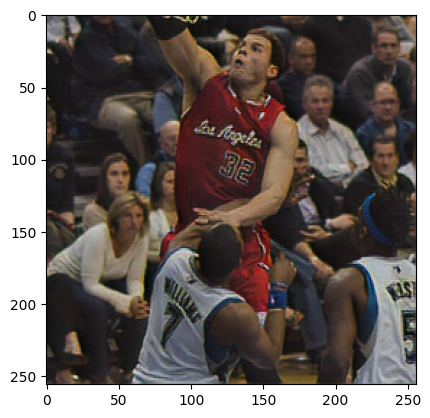

In [33]:
test_images = next(iter(photo_dataloader_valid))[0]
result_images_best_checkpoint = G_inference(test_images)
result_images_checkpoint_after_210_epochs = G(test_images.to(device))
print(result_images_best_checkpoint[0])
plt.imshow(np.transpose(result_images_best_checkpoint[0].detach().numpy(), (1, 2, 0)))

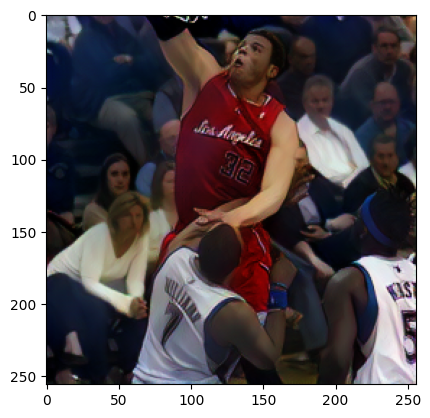

In [34]:
plt.imshow(np.transpose(result_images_checkpoint_after_210_epochs[0].cpu().detach().numpy(), (1, 2, 0)))

### Save weights for production release
In order to have a small file size for a production release, save only the weights of the generator to get a smaller artifact.

This should be the weights of the best checkpoint, but due to the bug described above, I take the latest version of the generator.

Filesize comparison:

Full checkpoint with Generator, Discriminator, Optimizer: 140MB

Generator only: 43MB

In [35]:
generator_release = {'last_epoch': 210,
                    'g_state_dict': G.state_dict(),
                   }
print("Save generator release")
torch.save(generator_release, checkpoint_dir + '/generator_release.pth')

Save generator release
